# **WorkShop de Inteligencia Artificial Congreso Chileno de Radiología 2022**


: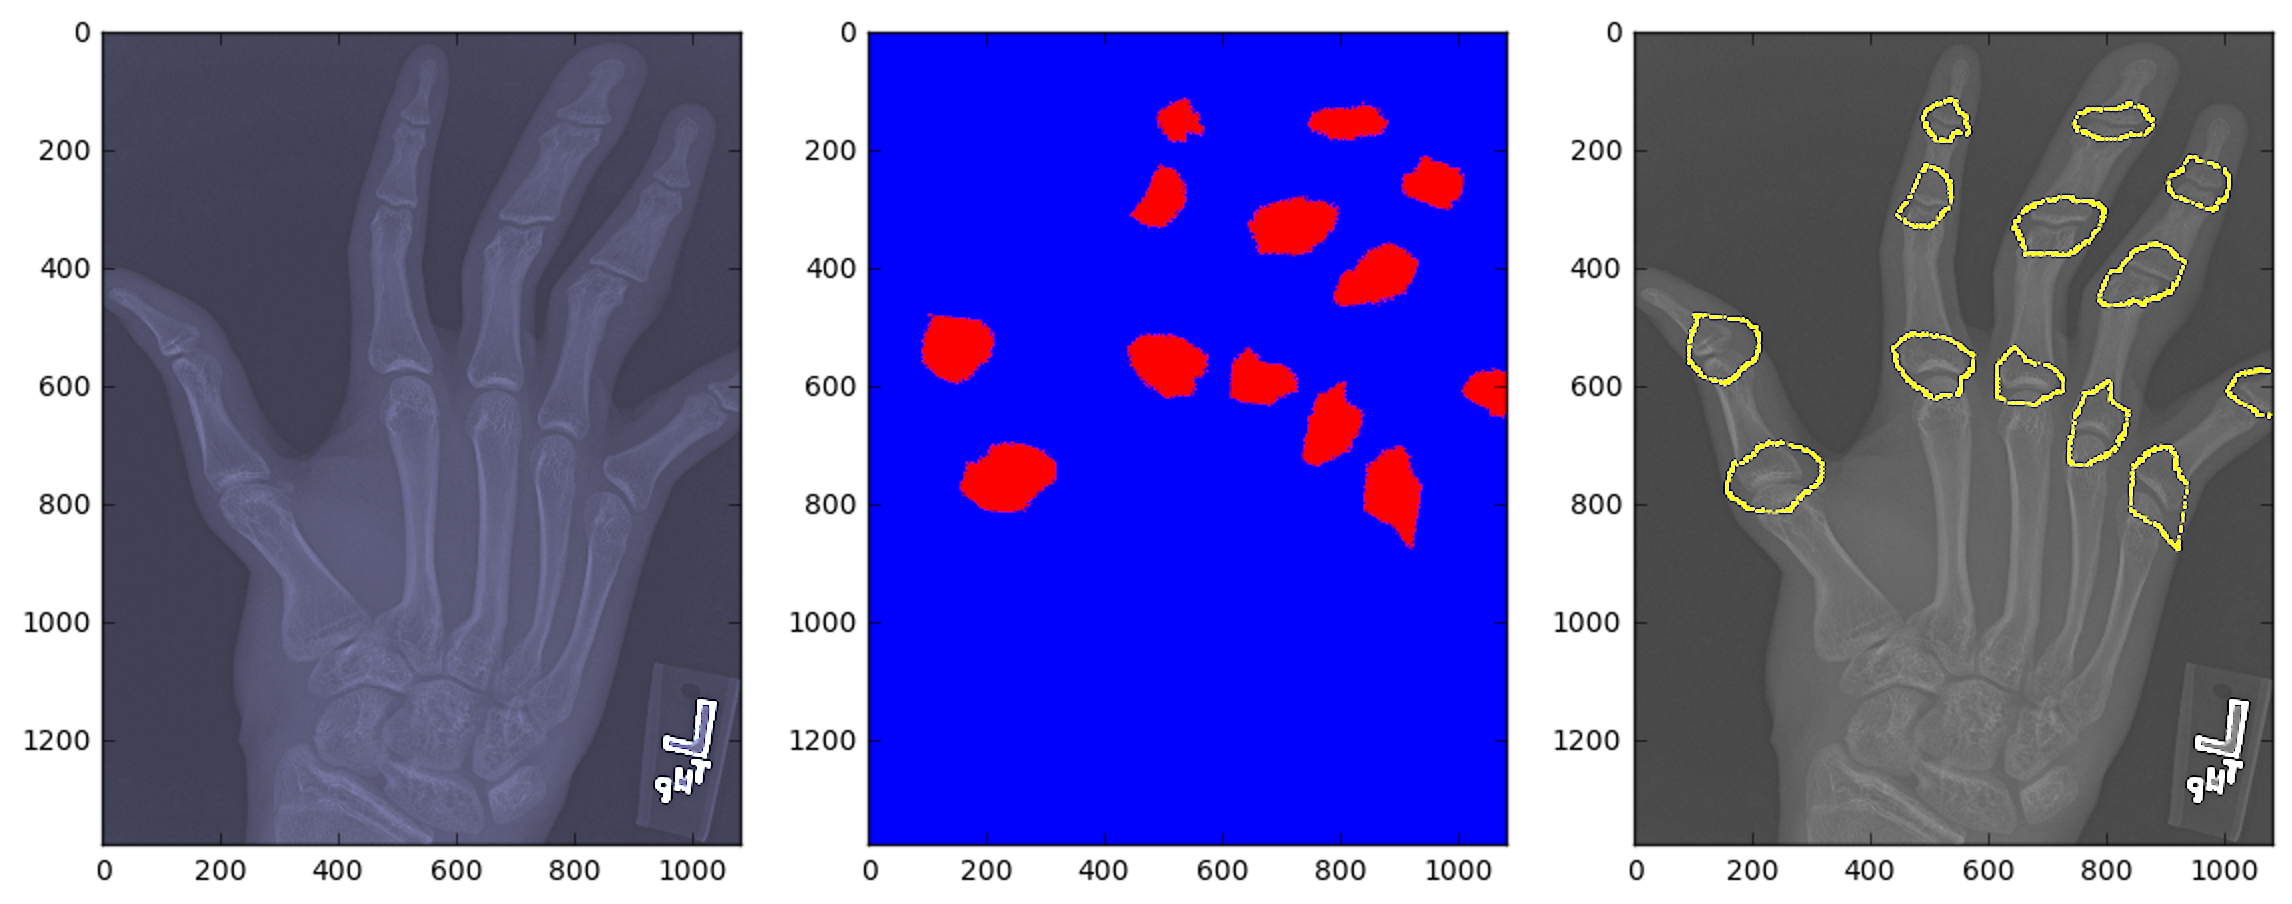

In [ ]:
## Librerias generales de manejo de datos numéricos
import numpy as np
import pandas as pd
import json
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

## Librerías de visualización
import matplotlib.pyplot as plt
from plotnine import*

## Librerias de keras para construcción y entrenamiento de Modelo Deep Learning
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, model_from_json
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten, Dropout, Input,concatenate
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
from tensorflow.keras.losses import MeanAbsoluteError
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import regularizers
from tensorflow.keras.regularizers import l1, l2

import requests
import warnings
warnings.filterwarnings('ignore')

## Descarga de token de kaggle que permite acceder al set de datos
json_response= requests.get("https://raw.githubusercontent.com/HectorHenriquez/Bone-Age-WorkShop-Congreso/main/kaggle.json")
token = json.loads(json_response.text)
with open("kaggle.json", "w") as outfile:
    json.dump(token, outfile)

## Carga de datos desde Kaggle
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

## Dataset
! kaggle datasets download hshenriquez/traindata-boneage-challenge
!unzip /content/traindata-boneage-challenge.zip

In [ ]:
## Carga de Tensor con imágenes
data = np.load('tensorBoneAgeTrain160x200.npy', allow_pickle=True)
print("Cantidad de imágenes:{},\nAncho de imágenes:{} pixeles, Alto de imágenes:{} pixeles".
      format(data.shape[0],data.shape[2],data.shape[1]))


In [ ]:
## Muestra aleatoria de las radiografías cargadas
index = np.random.randint(0,data.shape[0])
print('Imagen:', index)
plt.figure(figsize=(7,7))
plt.imshow(data[index,:,:], cmap='gray')
plt.show()

In [ ]:
## Carga de Data Clínica

url = 'https://raw.githubusercontent.com/HectorHenriquez/Bone-Age-WorkShop-Congreso/main/TrainDataBoneAgeChallenge.csv'

dataClinica = pd.read_csv(url)

## Previsualización de tabla de datos:
dataClinica.head(5)

In [ ]:
## Análisis exploratorio:

## Edades
print("Promedio de edad: {} años\n".format(round(data.mean()/12,2)))
(ggplot(dataClinica) + aes(x='boneage/12') + 
 geom_histogram(fill='steelblue', color='black') +
 theme_bw() +
 labs(title='Distribución de edades de los pacientes', x='años', y='recuento')+
 scale_x_continuous(breaks=list(range(0,21,1)))
)

In [ ]:
## Género
(
    ggplot(dataClinica)+
 aes(x='male', fill='male') +
 geom_bar(show_legend=False) + 
 theme_bw() +
 labs(title='Distribución de Género', y='recuento', x = 'Masculino' ) +
    scale_y_continuous(breaks=list(range(0,7500,500)))

)

In [ ]:
## Separación aleatoria de conjuntos de entrenamiento y prueba

index = np.array(list(range(0,data.shape[0])))

## Uso de semilla para que todos podamos tener la misma partición de datos
seed = 40

X_train, X_test, y_train, y_test = train_test_split(index, index, test_size=0.1, random_state=seed)

## Por razones de memoria, sólo usaremos los indices de la separación y los 
## aplicaremos directamente sobre el único set de datos de imágenes.

print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)

In [ ]:
## Preprocesamiento:
## 1. Normalización del valor de los pixeles (0 - 1)
## 2. Reshape: ajuste de las dimensiones esperadas del tensor. Formato: (numero de imagenes, altura, ancho, canales)
data = data/255
data = data.reshape(data.shape[0], data.shape[1], data.shape[2],1)
print(data.shape)

## Modelo de Red convolucional + data categórica: Modelo Híbrido

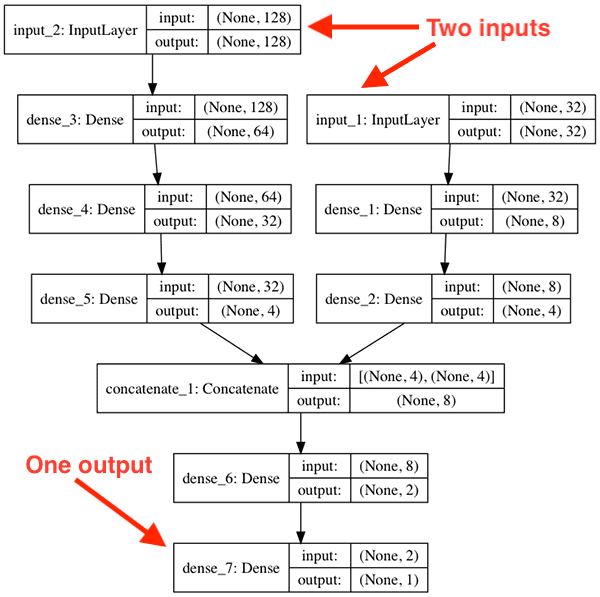

In [ ]:
## Definicion hiperparametros

LR = 0.001
EPOCHS = 15
BATCH_SIZE = 128  ## no superar los 128 debido a limites de memoria
VAL_SPLIT = 0.1
NEURONAS_CLASIFICADOR = 32
DROP_OUT = 0.1

In [ ]:
## Se utiliza arquitectura InceptionV3 desde Keras
## No se incluyen los pesos, ya que los pesos de ImageNet funcionan con imagenes en color.
## No se incluye "top", ya que re entrenaremos la capa de clasificación para nuestro problema.

#################################################################################
## Primer Modelo Convolucional para las imagenes.

base_model = InceptionV3(weights= None, include_top=False, input_shape=(data.shape[1],
                                                                       data.shape[2],1))
x1 = base_model.output
x1 = GlobalAveragePooling2D()(x1)
x1 = Flatten()(x1)
x1 = Dense(NEURONAS_CLASIFICADOR, activation='relu')(x1)
x1 = Dropout(DROP_OUT)(x1)
x1 = Dense(1, activation='linear')(x1)

x1 = Model(inputs=base_model.input, outputs=x1)

## Se definen todas las capas entrenables
for layer in base_model.layers:
    layer.trainable = True
################################################################################

################################################################################
## Segundo Modelo que aceptara variables clínicas: Genero

inputGender = Input(shape=(1,))
x2 = Dense(1, activation="relu")(inputGender)
x2 = Model(inputs=inputGender, outputs=x2)
################################################################################

################################################################################
################################################################################
# Se crea una capa de concatenación para los dos Modelos
combined = concatenate([x1.output, x2.output])

## La capa de concatenación termina en una capa de Regresión
y = Dense(1, activation="relu", kernel_regularizer=l1(0.000005))(combined)
y = Dense(1, activation="linear")(y)

## Modelo Final tiene 2 input [imagenes + data] y una capa de salida
model = Model(inputs=[x1.input, x2.input], outputs=y)
################################################################################
################################################################################

## Compilado y entrenamiento del Modelo

model.compile(optimizer=Adam(learning_rate=LR), loss='mae')

checkpoint_filepath = '/content/checkpoint'

model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)


history = model.fit(x=[data[X_train], dataClinica['male'][X_train]], 
                    y=dataClinica['boneage'][y_train], 
                    epochs=EPOCHS, 
                    batch_size=BATCH_SIZE, 
					verbose=1, 
                    validation_split = VAL_SPLIT, 
                    callbacks=[model_checkpoint_callback], shuffle=False)

model.load_weights(checkpoint_filepath)

model.save('BoneAgeInceptionModelSOCHRADI.h5')


In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
## Evaluación del Modelo en los datos de test:

model.evaluate([data[X_test], dataClinica['male'][X_test]], dataClinica['boneage'][y_test])

In [ ]:

numero = np.random.randint(0, data[X_test].shape[0])
print('caso Test:', numero)

img = data[X_test][numero]
img_tensor = np.expand_dims(img, axis=0) 

genero = dataClinica['male'][y_test].iloc[numero]
genero = np.array(genero)
genero = np.expand_dims(genero, axis=0) 

edad = dataClinica['boneage'][y_test].iloc[numero]


prediccion = model.predict([img_tensor,genero])

print('Prediccion Modelo:{} años'.format(prediccion/12))
print('Edad real del paciente: {} años'.format(edad/12))
print('Diferencia de edad: {} años'.format(abs(edad-prediccion)/12))
plt.figure(figsize=(5,5))
plt.imshow(img_tensor.reshape(200,160), cmap='viridis')
plt.show()

### Carga de Modelo Pre - entrenado

#### Descargue el modelo pre entrenado InceptionV3 desde el link de google Drive o directamente desde Kaggle

https://drive.google.com/drive/folders/1_Ae7S1Z6qCxHEf-uQYi9nUhgesSeGs-e?usp=sharing

In [ ]:
## Descargamos Modelo Pre entrenado

! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

! kaggle datasets download hshenriquez/bone-age-pretrained-model

!unzip /content/bone-age-pretrained-model.zip

In [ ]:
modelPretrained =  load_model('/content/BoneAgeInceptionModel160x200v21-06.h5')

In [ ]:
## resumen de la arquiectura del modelo cargado
print(modelPretrained.summary())

## Evaluando el Modelo

In [ ]:
## rendimiento general del Modelo

modelPretrained.evaluate([data[X_test], dataClinica['male'][X_test]], dataClinica['boneage'][y_test])

In [ ]:
## Bland - Altman
y_pred = modelPretrained.predict([data[X_test], dataClinica['male'][X_test]])

y_pred = y_pred.reshape(y_pred.shape[0],)

f, ax = plt.subplots(1, figsize = (8,5))
sm.graphics.mean_diff_plot(y_pred, dataClinica['boneage'][y_test] , ax = ax)
plt.show()

### Comparacion de subgrupos

* Sexo
* Grupos etarios

In [ ]:
### Evaluacion pacientes masculinos
df_test = dataClinica.iloc[X_test]

modelPretrained.evaluate([data[X_test[df_test['male'] == True]], dataClinica['male'][X_test[df_test['male'] == True]]], 
                         dataClinica['boneage'][X_test[df_test['male'] == True]])

In [ ]:
### Evaluacion pacientes femeninas

modelPretrained.evaluate([data[X_test[df_test['male'] == False]], dataClinica['male'][X_test[df_test['male'] == False]]], 
                         dataClinica['boneage'][X_test[df_test['male'] == False]])

## Probando el modelo final


In [ ]:

numero = np.random.randint(0, data[X_test].shape[0])
print('caso Test:', numero)

img = data[X_test][numero]
img_tensor = np.expand_dims(img, axis=0) 

genero = dataClinica['male'][y_test].iloc[numero]
genero = np.array(genero)
genero = np.expand_dims(genero, axis=0) 

edad = dataClinica['boneage'][y_test].iloc[numero]

prediccion = modelPretrained.predict([img_tensor,genero])

print('Predicción Modelo:{} años'.format(prediccion/12))
print('Edad ósea del paciente: {} años'.format(edad/12))
print('Diferencia de edad: {} años'.format(abs(edad-prediccion)/12))
plt.figure(figsize=(7,7))
plt.imshow(img_tensor.reshape(200,160), cmap='gray')
plt.show()